This is to test TTS models with benchmark sentences for speech synthesis.

Before running this script please DON'T FORGET: 
- to set file paths.
- to download related model files from TTS and WaveRNN.
- to checkout right commit versions (given next to the model) of TTS and WaveRNN.
- to set the right paths in the cell below.

Repositories:
- TTS: https://github.com/mozilla/TTS
- WaveRNN: https://github.com/erogol/WaveRNN

In [1]:
TTS_PATH = "../../"
WAVERNN_PATH ="../../"

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import json
import numpy as np
from collections import OrderedDict
from matplotlib import pylab as plt

%pylab inline
rcParams["figure.figsize"] = (16,5)

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
sys.path.append(WAVERNN_PATH) # set this if TTS is not installed globally

import librosa
import librosa.display

from TTS.models.tacotron2 import Tacotron2
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config, setup_model
from TTS.utils.text import text_to_sequence
from TTS.utils.synthesis import synthesis, synthesis2
from TTS.utils.visual import visualize

import IPython
from IPython.display import Audio

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

Populating the interactive namespace from numpy and matplotlib


/search/hadoop02/suanfa/anaconda3/envs/tacotron2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def tts(model, text, CONFIG, use_cuda, ap, ap_vocoder, use_gl, figures=True):
    t_1 = time.time()
    waveform, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis(model, text, CONFIG, use_cuda, ap, speaker_id, False, CONFIG.enable_eos_bos_chars, do_trim_silence=False)
    if CONFIG.model == "Tacotron" and not use_gl:
        # coorect the normalization differences b/w TTS and the Vocoder.
        mel_postnet_spec = ap.out_linear_to_mel(mel_postnet_spec.T).T
    mel_postnet_spec = ap._denormalize(mel_postnet_spec)
    mel_postnet_spec = ap_vocoder._normalize(mel_postnet_spec)
    print(" > Tacotron2-time: {}".format(time.time() - t_1))
    if not use_gl:
        waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=3000, overlap=100, ap=ap_vocoder)

    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

In [4]:
def tts2(model, text, CONFIG, use_cuda, ap, ap_vocoder, use_gl, figures=False, target=3000, overlap=500, create_gl=False):
    t_1 = time.time()
    wave_gl, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis2(model, text, CONFIG, use_cuda, ap, speaker_id, False, CONFIG.enable_eos_bos_chars, do_trim_silence=False, create_gl=create_gl)
    if CONFIG.model == "Tacotron" and not use_gl:
        # coorect the normalization differences b/w TTS and the Vocoder.
        mel_postnet_spec = ap.out_linear_to_mel(mel_postnet_spec.T).T
    mel_postnet_spec = ap._denormalize(mel_postnet_spec)
    mel_postnet_spec = ap_vocoder._normalize(mel_postnet_spec)
    print(" > Tacotron2-time: {}".format(time.time() - t_1))
    if not use_gl:
        waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=target, overlap=overlap, ap=ap_vocoder)
        # waveform = wavernn.generate(mel_postnet_spec.T.unsqueeze(0).cuda(), batched=batched_wavernn, target=3000, overlap=100, ap=ap_vocoder)
    print("\n >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)
    if create_gl:
        IPython.display.display(Audio(wave_gl, rate=CONFIG.audio['sample_rate']))
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

In [5]:
# Set constants
# new Biaobei-December-11-2019_08+24AM-536ef91
# old Biaobei-November-29-2019_07+21AM-649312f
ROOT_PATH = '../../TTS/output/Biaobei-December-11-2019_08+24AM-536ef91/'
MODEL_PATH = ROOT_PATH + '/best_model.pth.tar'
CONFIG_PATH = '../../TTS/config.json'
OUT_FOLDER = '../output/benchmark_samples/'
CONFIG = load_config(CONFIG_PATH)
VOCODER_MODEL_PATH = "../output/WaveRNN-December-12-2019_05+43PM-e8886be/model_checkpoints/best_model.pth.tar"
VOCODER_CONFIG_PATH = "../config.json"
VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
use_cuda = True

# Set some config fields manually for testing
CONFIG.windowing = False
CONFIG.prenet_dropout = True
CONFIG.separate_stopnet = True
CONFIG.use_forward_attn = True
CONFIG.forward_attn_mask = True
CONFIG.stopnet = True

# Set the vocoder
use_gl = False # use GL if True
batched_wavernn = True    # use batched wavernn inference if True

In [6]:
# LOAD TTS MODEL
from TTS.utils.text.symbols import symbols, phonemes

# multi speaker 
if CONFIG.use_speaker_embedding:
    speakers = json.load(open(f"{ROOT_PATH}/speakers.json", 'r'))
    speakers_idx_to_id = {v: k for k, v in speakers.items()}
else:
    speakers = []
    speaker_id = None

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, len(speakers), CONFIG)

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()
print(cp['step'])
print(cp['r'])

# set model stepsize
if 'r' in cp:
    model.decoder.set_r(cp['r'])

 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:48000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:2049
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:125.0
 | > mel_fmax:7600.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > sound_norm:False
 | > n_fft:4096
 | > hop_length:600
 | > win_length:2400
80650
1


In [7]:
# LOAD WAVERNN
if use_gl == False:
    from WaveRNN.models.wavernn import Model
    from WaveRNN.utils.audio import AudioProcessor as AudioProcessorVocoder
    bits = 10
    ap_vocoder = AudioProcessorVocoder(**VOCODER_CONFIG.audio)    
    wavernn = Model(
            rnn_dims=512,
            fc_dims=512,
            mode=VOCODER_CONFIG.mode,
            mulaw=VOCODER_CONFIG.mulaw,
            pad=VOCODER_CONFIG.pad,
            upsample_factors=VOCODER_CONFIG.upsample_factors,
            feat_dims=VOCODER_CONFIG.audio["num_mels"],
            compute_dims=128,
            res_out_dims=128,
            res_blocks=10,
            hop_length=ap_vocoder.hop_length,
            sample_rate=ap_vocoder.sample_rate,
            use_upsample_net = True,
            use_aux_net = True
        ).cuda()

    check = torch.load(VOCODER_MODEL_PATH)
    wavernn.load_state_dict(check['model'], strict=False)
    if use_cuda:
        wavernn.cuda()
    wavernn.eval();
    print(check['step'])

 > Setting up Audio Processor...
 | > fft size: 4096, hop length: 600, win length: 2400
 | > Audio Processor attributes.
   | > bits:None
   | > sample_rate:48000
   | > num_mels:80
   | > min_level_db:-100
   | > frame_shift_ms:12.5
   | > frame_length_ms:50
   | > ref_level_db:20
   | > num_freq:2049
   | > power:1.5
   | > preemphasis:0.98
   | > griffin_lim_iters:60
   | > signal_norm:True
   | > symmetric_norm:True
   | > mel_fmin:125.0
   | > mel_fmax:7600.0
   | > max_norm:4.0
   | > clip_norm:True
   | > do_trim_silence:True
   | > n_fft:4096
   | > hop_length:600
   | > win_length:2400
440136


### Comparision with https://mycroft.ai/blog/available-voices/

In [ ]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "dang1 qian2 mo2 xing2 yi3 jing1 you3 le5 bu2 cuo4 de5 xiao4 guo3. ran2 er2, you2 yu2 xun4 lian4 shu4 ju4 que1 shao3 biao1 dian3, jia1 shang4 xun4 lian4 yu3 liao4 bi2 jiao2 xiao3, suo2 yi3, ju4 zi5 ting2 dun4 hai2 cun2 zai4 yi4 xie1 bu4 wen3 ding4 xing4."
align, spec, stop_tokens, wav = tts2(model, sentence, CONFIG, use_cuda, ap, ap_vocoder, use_gl=use_gl, figures=True, target=4000, overlap=150, create_gl=False)

 > Tacotron2-time: 2.1183741092681885
480700/483000 -- batch_size: 23 -- gen_rate: 24.6 kHz -- x_realtime: 0.5  
 >  Run-time: 21.90093231201172


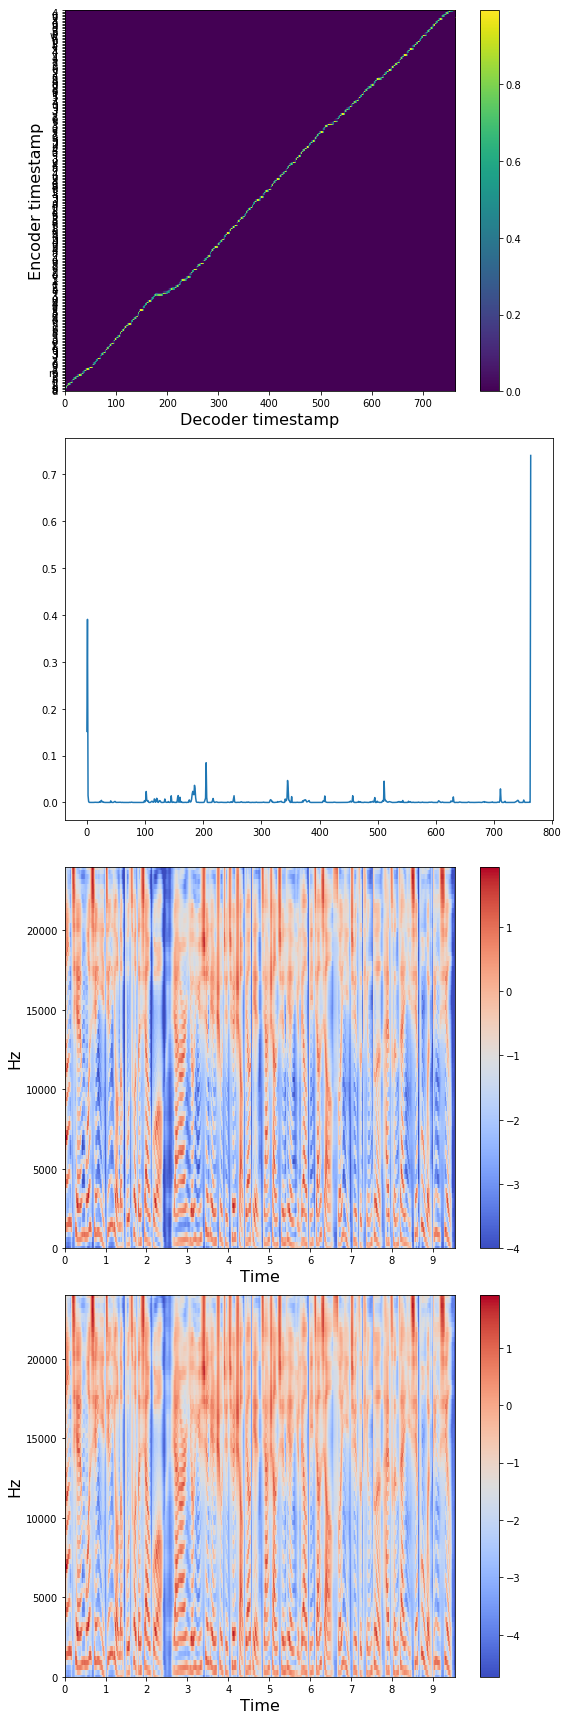

In [9]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "dang1 qian2 mo2 xing2 yi3 jing1 you3 le5 bu2 cuo4 de5 xiao4 guo3. ran2 er2, you2 yu2 xun4 lian4 shu4 ju4 que1 shao3 biao1 dian3, jia1 shang4 xun4 lian4 yu3 liao4 bi2 jiao2 xiao3, suo2 yi3, ju4 zi5 ting2 dun4 hai2 cun2 zai4 yi4 xie1 bu4 wen3 ding4 xing4."
align, spec, stop_tokens, wav = tts2(model, sentence, CONFIG, use_cuda, ap, ap_vocoder, use_gl=use_gl, figures=True, target=20000, overlap=500, create_gl=False)

 > Tacotron2-time: 2.2655279636383057
426300/435000 -- batch_size: 87 -- gen_rate: 88.5 kHz -- x_realtime: 1.8  
 >  Run-time: 7.239741802215576


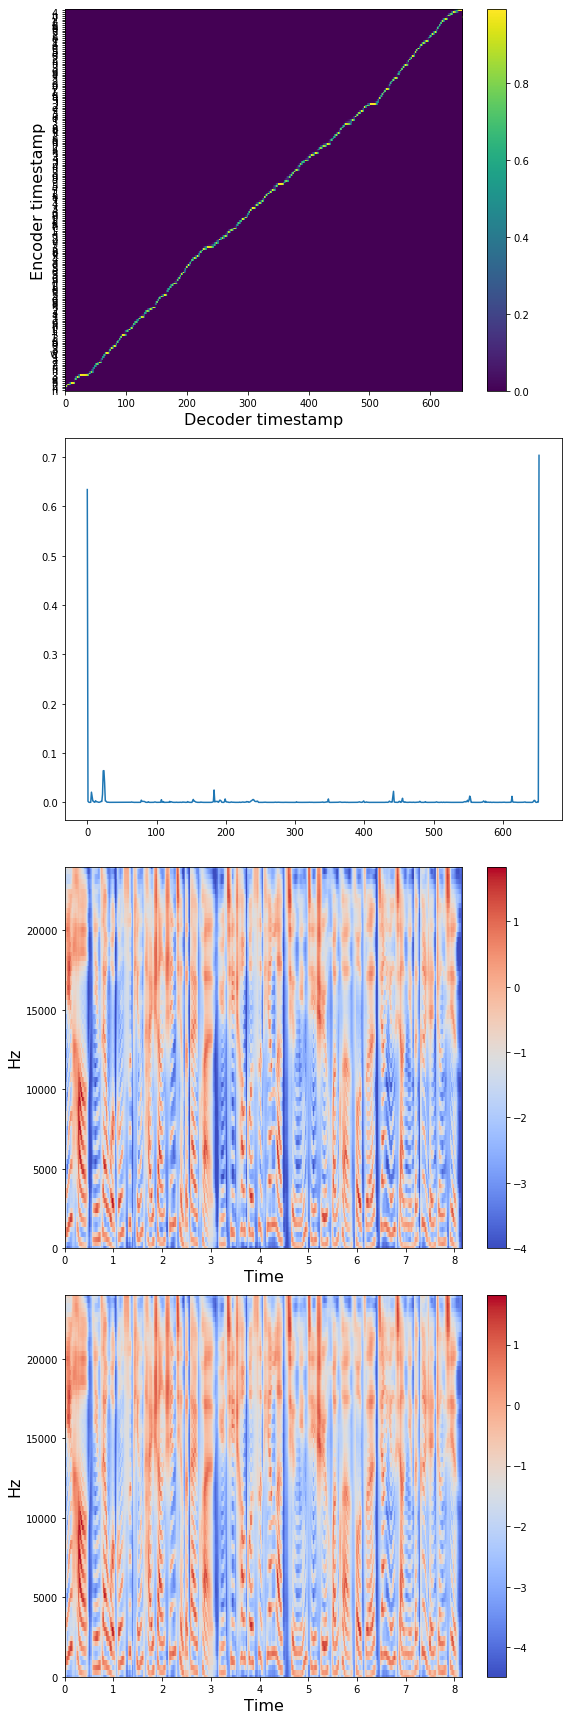

In [8]:
model.eval()
model.decoder.max_decoder_steps = 3000
speaker_id = None
sentence =  "nin2 hao3, nin2 zai4 wo3 gong1 si1 ping2 tai2 shang4 shen1 qing3 de5 dai4 kuan3, yu2 qi1 chao1 guo4 si4 tian1 le5, qing3 nin2 ji2 shi2 huan2 kuan3, fou3 ze2, jiang1 ying2 xiang3 nin2 de5 ge4 ren2 zheng1 xin4."
align, spec, stop_tokens, wav = tts2(model, sentence, CONFIG, use_cuda, ap, ap_vocoder, use_gl=use_gl, figures=True, target=4000, overlap=500, create_gl=False)

 > Tacotron2-time: 1.7920341491699219
412200/414000 -- batch_size: 18 -- gen_rate: 18.8 kHz -- x_realtime: 0.4  
 >  Run-time: 23.916550397872925


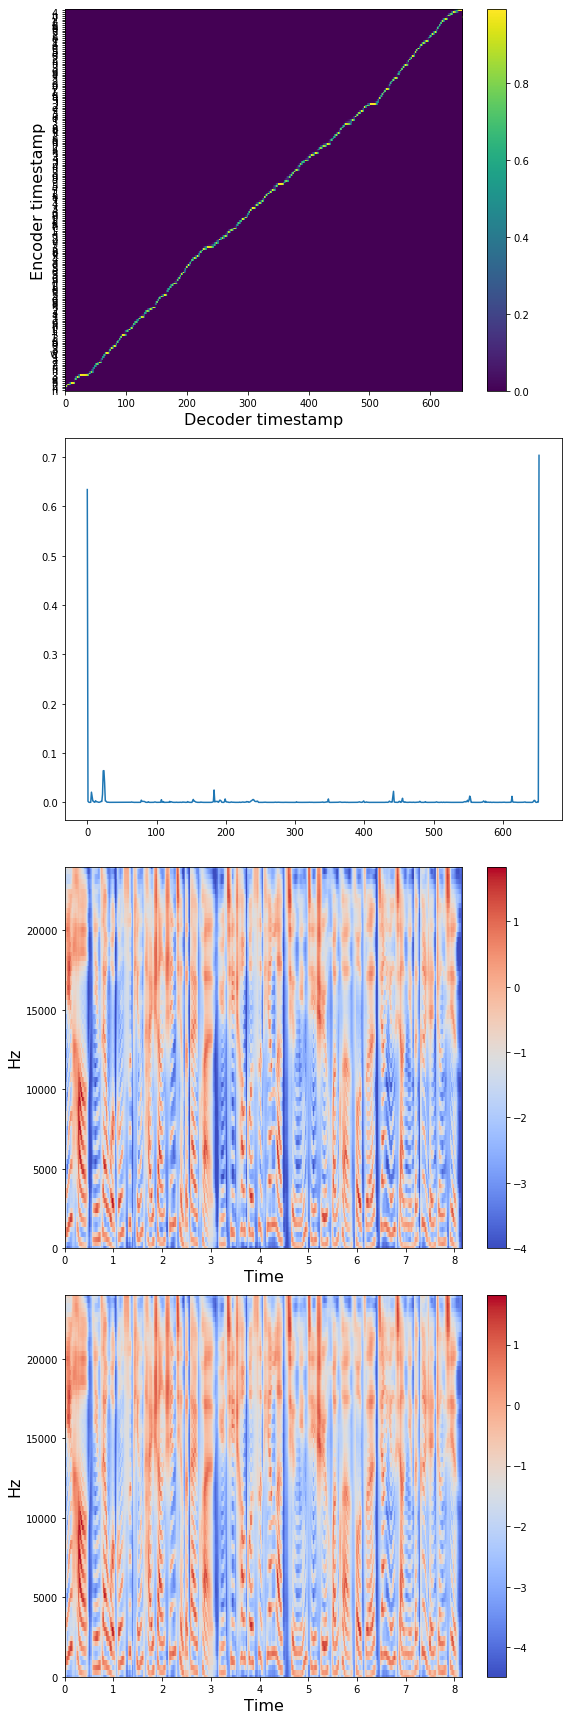

In [15]:
model.eval()
model.decoder.max_decoder_steps = 3000
speaker_id = None
sentence =  "nin2 hao3, nin2 zai4 wo3 gong1 si1 ping2 tai2 shang4 shen1 qing3 de5 dai4 kuan3, yu2 qi1 chao1 guo4 si4 tian1 le5, qing3 nin2 ji2 shi2 huan2 kuan3, fou3 ze2, jiang1 ying2 xiang3 nin2 de5 ge4 ren2 zheng1 xin4."
align, spec, stop_tokens, wav = tts2(model, sentence, CONFIG, use_cuda, ap, ap_vocoder, use_gl=use_gl, figures=True, target=22000, overlap=500, create_gl=False)